In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from jax import random, numpy as jnp
from stadion.models import LinearSDE, MLPSDE
from pprint import pprint
from stadion import kds_loss
import numpy as onp
import ot

2025-03-04 12:07:33.555190: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741108053.565832 1408930 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741108053.569092 1408930 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
from nn import NNSDE
from nonlinear_script import *

In [3]:
n = 1000
d = 2
r = 2
n_envs = 10
n_test_envs = 10
epsilon = 0.5
gamma = 0.95
activation = "mixed"
model_activation = "learned"

model_hidden_size = 16

bandwidth = [1.0, 3.0, 5.0, 7.0]
steps = 50000
estimator = "linear"
reg = 0.000

scale = 1e-2
intv_scale = 0.3

n_samples_burnin=200
learning_rate = 0.003
weight_decay = 0.0001

seed = 9

In [4]:
key = random.PRNGKey(seed)

true_model = build_model(r, activation, epsilon, gamma, n_samples_burnin)
key, true_model, param = initialize_model(key, true_model, d)

# param["mlp_0"] = jax.numpy.eye(d, r)
# param["mlp_1"] = jax.numpy.eye(r, d)
# true_model.param = param

key, intv_param, datasets, targets = build_data(key, true_model, d, n_envs, intv_scale, n)
key, test_intv_param, test_datasets, test_targets = build_data(key, true_model, d, n_test_envs, intv_scale, n)


model = build_model(model_hidden_size, model_activation, epsilon, gamma, n_samples_burnin)
key, model = fit_model(key, model, datasets, targets, intv_param, bandwidth, steps, estimator,
                       reg, learning_rate, weight_decay, scale)

W0000 00:00:1741108065.555977 1408930 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


step:  5000 kds:     0.102773  | min remain:  1.7  sec/step: 0.002
step: 10000 kds:     0.068203  | min remain:  1.2  sec/step: 0.002
step: 15000 kds:     0.061615  | min remain:  1.0  sec/step: 0.002
step: 20000 kds:     0.055553  | min remain:  0.9  sec/step: 0.002
step: 25000 kds:     0.045590  | min remain:  0.7  sec/step: 0.002
step: 30000 kds:     0.040182  | min remain:  0.6  sec/step: 0.002
step: 35000 kds:     0.032333  | min remain:  0.4  sec/step: 0.002
step: 40000 kds:     0.028409  | min remain:  0.3  sec/step: 0.002
step: 45000 kds:     0.024936  | min remain:  0.1  sec/step: 0.002
step: 50000 kds:     0.013866  | min remain:  0.0  sec/step: 0.002


In [5]:
wds, mean, std = assess_model_mean(key, model, n_test_envs, test_intv_param, test_datasets, n)
print(wds)
print(mean, std)

[0.5466296  1.2692306  0.52569604 1.7351635  1.0973209  0.7191797
 0.67373115 0.73045534 1.58702    0.5257625 ]
0.9410189 0.42960477


In [6]:
wds, mean, std = assess_model_mean(key, true_model, n_test_envs, test_intv_param, test_datasets, n)
print(wds)
print(mean, std)

[0.3858452  0.00502397 0.97718513 0.19844022 0.06330224 0.18185687
 0.04139787 0.37095636 0.17149703 0.00942712]
0.24049321 0.27761534


In [7]:
#W2
wds, mean, std = assess_model(key, model, n_test_envs, test_intv_param, test_datasets, n, ot_epsilon = 0.2)
print(wds)
print(mean, std)

wds, mean, std = assess_model(key, true_model, n_test_envs, test_intv_param, test_datasets, n, ot_epsilon = 0.2)
print(wds)
print(mean, std)

[0.9499201 2.2785554 1.1805704 3.6855989 1.9508778 1.582548  1.1744727
 1.2682976 2.9092863 0.9327633]
1.791289 0.87273854
[0.63952374 0.06975785 2.1418588  0.38957444 0.15392148 0.42535296
 0.11243368 0.6065094  0.3154815  0.07226531]
0.4926679 0.584451


In [8]:
#s:0.5363229 0.24096417
#s2:0.90338963 0.43753132
#l:0.9410189 0.42960477
#l2:1.791289 0.87273854
#t:0.24049321 0.27761534
#t2:0.4926679 0.584451

In [9]:
#s:
#s2:
#l:
#l2:
#t:
#t2:

In [10]:
#s:
#s2:
#l:
#l2:
#t:
#t2:

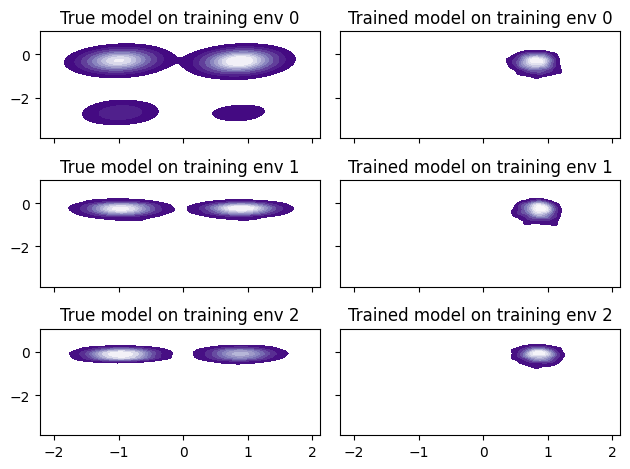

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

if d == 2:

    total = 3

    pred_datasets = []
    for k in range(total):
        local_intv_param = intv_param.index_at(k)
        key, subk = random.split(key)
        data = model.sample(subk, n_samples = n, intv_param = local_intv_param)
        pred_datasets.append(data)

    fig, axes = plt.subplots(nrows=total,ncols=2,sharex=True, sharey=True)

    
    for k in range(total):
    
        x = datasets[k][:,0]
        y = datasets[k][:,1]
        sns.kdeplot(x=x, y=y, ax = axes[k,0], fill=True,cmap="Purples_r")
        axes[k,0].set_title(f"True model on training env {k}")
        
        x = pred_datasets[k][:,0]
        y = pred_datasets[k][:,1]
        sns.kdeplot(x=x, y=y, ax = axes[k,1], fill=True,cmap="Purples_r")
        axes[k,1].set_title(f"Trained model on training env {k}")

    plt.tight_layout()
    plt.show()


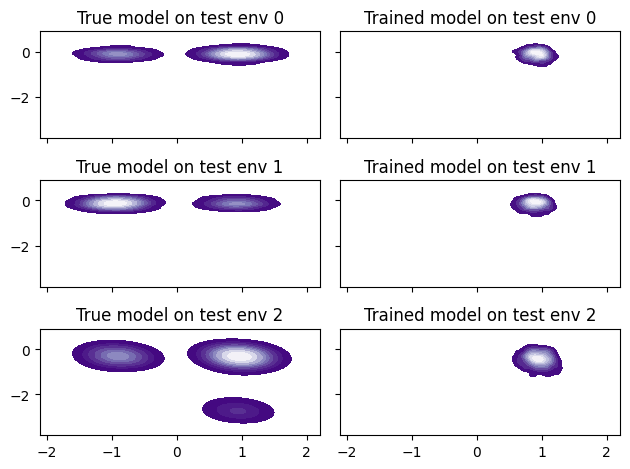

In [12]:
if d == 2:

    total = 3

    pred_test_datasets = []
    for k in range(total):
        local_intv_param = test_intv_param.index_at(k)
        key, subk = random.split(key)
        data = model.sample(subk, n_samples = n, intv_param = local_intv_param)
        pred_test_datasets.append(data)

    fig, axes = plt.subplots(nrows=total,ncols=2,sharex=True, sharey=True)

    for k in range(total):
    
        x = test_datasets[k][:,0]
        y = test_datasets[k][:,1]
        sns.kdeplot(x=x, y=y, ax = axes[k,0], fill=True,cmap="Purples_r")
        axes[k,0].set_title(f"True model on test env {k}")
        
        x = pred_test_datasets[k][:,0]
        y = pred_test_datasets[k][:,1]
        sns.kdeplot(x=x, y=y, ax = axes[k,1], fill=True,cmap="Purples_r")
        axes[k,1].set_title(f"Trained model on test env {k}")

    plt.tight_layout()
    plt.show()

In [13]:
print(model.param)

ModelParameters
{'A': Array([[ 1.22507650e-03, -5.15668932e-03, -9.65224928e-04,
        -3.05810652e-04, -9.33930045e-04,  1.59354426e-03,
         1.39112060e-03, -3.63584096e-03,  9.27538553e-04,
         1.30885269e-03,  1.94516289e-03,  3.00244195e-03,
         1.08995533e-03, -5.72827703e-04,  2.42177723e-03,
         6.16197765e-04, -1.78697170e-03,  9.76744690e-04,
        -3.51265166e-03, -2.04372453e-03],
       [-5.44774719e-02, -7.04671666e-02, -7.76118264e-02,
        -6.71536475e-02, -6.63456544e-02, -7.73131549e-02,
        -7.93995783e-02, -8.63095298e-02, -6.50290400e-02,
        -4.28007878e-02, -6.99141920e-02, -7.85480216e-02,
        -7.85558671e-02, -8.61221179e-02, -7.40423873e-02,
        -6.68110773e-02, -8.60565007e-02, -7.89693296e-02,
        -8.70368034e-02, -7.02107474e-02],
       [-5.98714463e-02, -8.24354589e-02, -5.56825884e-02,
        -5.61081953e-02, -6.89130649e-02, -5.42322882e-02,
        -4.32406068e-02, -7.98111632e-02, -6.56085610e-02,
       

In [14]:
print(true_model.param)

ModelParameters
{'log_reversion': Array([0., 0.], dtype=float32),
 'mlp_0': Array([[1., 0.],
       [0., 1.]], dtype=float32),
 'mlp_1': Array([[1., 0.],
       [0., 1.]], dtype=float32),
 'mlp_b_0': Array([-0.,  0.], dtype=float32)}
